# 1. Pre-processing

- 모듈 불러오기

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc, mean_squared_error, classification_report
from sklearn import  model_selection
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from vecstack import stacking, StackingTransformer
from xgboost import XGBClassifier
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer
from sklearn.linear_model import LogisticRegression

- titanic 데이터를 불러오기

In [2]:
titan_df = pd.read_csv('./titanic.csv', encoding='utf-8', engine='python')

- Age 결측치를 채우기 (결측치에 랜덤하게 25%~75%의 값을 적용한다.)

In [3]:
# 기술통계량 확인
titan_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
# Age에 랜덤하게 백분위수 25%~75%까지의 값을 랜덤하게 대치하기 위한 함수
def replace_age(age_quantile_25, age_quantile_75):
    return np.random.randint(age_percentiles_25, age_percentiles_75)

In [5]:
# Age의 백분위수 25%
age_percentiles_25 = titan_df.Age.quantile(.25)
# Age의 백분위수 75%
age_percentiles_75 = titan_df.Age.quantile(.75)

# Age에 랜덤하게 백분위수 25%~75%까지의 값을 랜덤하게 대치
titan_df.Age = titan_df.Age.apply(lambda x : replace_age(age_percentiles_25, age_percentiles_75) if pd.isna(x) else x)

- 불필요한 데이터 제거

In [6]:
# Embarked에 2개의 결측치 제거
titan_df.dropna(subset=['Embarked'], inplace=True)

In [7]:
# 필요없는 컬럼 제거
titan_df.drop(columns=['Cabin', 'Ticket', 'Name', 'PassengerId'], inplace=True)

# target(Survived) column만 나눠놓은 것
target_df = titan_df['Survived']
# Survived column을 지우고 실제로 train_split 할 데이터
data_df = titan_df.drop(columns=['Survived'])


- Train과 Test로 분할 (7:3)

In [8]:
# 7:3의 비율, seed는 0으로 데이터를 train과 test로 나누는 과정
x_train, x_test, y_train, y_test = model_selection.train_test_split(data_df, target_df,
                                                                    stratify=target_df,
                                                                    test_size=0.3,
                                                                    random_state=42)

- Numerical => StandardScaler & Categorical => OneHotEncoder 
- Pipeline으로 동시에 진행

In [9]:
# 연속형 데이터
numeric_features = ['SibSp', 'Parch', 'Age', 'Fare']
# 연속형 데이터 encoder
numeric_transformer = StandardScaler()
# 범주형 데이터
categorical_features = ['Sex', 'Pclass', 'Embarked']
# 범주형 데이터 encoder
categorical_transformer = OneHotEncoder(categories='auto', handle_unknown='ignore') 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
)

In [10]:
preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])

In [11]:
# x_train데이터 학습시키는 과정
preprocessor_pipe.fit(x_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['SibSp', 'Parch', 'Age',
                                                   'Fare']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Pclass',
                                                   'Embarked'])]))])

In [12]:
# x_train의 학습을 토대로 One-HotEncoding(), StandardScaler() 적용
x_train_transformed = preprocessor_pipe.transform(x_train)
x_test_transformed = preprocessor_pipe.transform(x_test)

## DecisionTreeClassifier

In [13]:
# 의사결정나무 불러오기
from sklearn.tree import DecisionTreeClassifier

In [14]:
# 의사결정 나무 불러오기 => 학습 시키기

clf = DecisionTreeClassifier()
clf.fit(x_train_transformed, y_train)

DecisionTreeClassifier()

In [15]:
# y값 예측하기

y_pred = clf.predict(x_test_transformed)

In [16]:
# acc 체점

print(accuracy_score(y_test, y_pred))

0.7453183520599251


## Support Vector Machine & GridSearch

In [17]:
# GridSearch

# 아래 param_grid dict 의 C & gamma 에 후보 Hyper-params 값들을 리스트업
param_grid = {'C' : [0.1, 1, 10, 100], 
             'gamma' : [1, 0.1, 0.01, 0.001],
             'kernel' : ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1)

grid.fit(x_train_transformed, y_train)
print('The best parameters are ', grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
The best parameters are  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [18]:
grid_predictions = grid.predict(x_train_transformed)

print("Accuracy on Training set: {:.3f}".format(grid.score(x_train_transformed, y_train)))
print("Accuracy on Test set: {:.3f}".format(grid.score(x_test_transformed, y_test)))

Accuracy on Training set: 0.836
Accuracy on Test set: 0.813


## Stacking & BayesSearch

- 1단계 모델들 (ExtraTrees, RandomForest, XGB, DecisionTree, Logistic, SVC)

In [19]:
# Stack하기 위한 모델들
estimators = [ 
    ('ExtraTrees', ensemble.ExtraTreesClassifier(random_state = 0, n_jobs = -1, n_estimators = 100, max_depth = 3)),
    ('RandomForest', ensemble.RandomForestClassifier(random_state = 0, n_jobs = -1, n_estimators = 100, max_depth = 3)),
    ('XGB', XGBClassifier(seed = 0, n_jobs = -1, learning_rate = 0.1, n_estimators = 100, max_depth = 3, eval_metric='mlogloss')),
    ('DecisionTree', DecisionTreeClassifier()),
    ('Logistic', LogisticRegression()),
    ('SVC', SVC(C=1, gamma=0.1, kernel='rbf')),
]

In [20]:
# stacking 정의
stack = StackingTransformer(estimators, 
                            regression = False, 
                            metric = accuracy_score, 
                            n_folds = 4, stratified = True, shuffle = True, 
                            random_state = 0, verbose = 1) 

In [21]:
# fit을 통해 각 모델들 점수를 보고 학습
stack = stack.fit(x_train_transformed, y_train)

# transform을 통해 train결과를 S_train에 넣음
S_train = stack.transform(x_train_transformed)
# transform을 통해 test결과를 S_test에 넣음
S_test = stack.transform(x_test_transformed)


task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
variant:      [A]
n_estimators: [6]

estimator  0: [ExtraTrees: ExtraTreesClassifier]
    MEAN:     [0.79904880] + [0.01515596]

estimator  1: [RandomForest: RandomForestClassifier]
    MEAN:     [0.80708230] + [0.01747128]

estimator  2: [XGB: XGBClassifier]
    MEAN:     [0.81822787] + [0.03218983]

estimator  3: [DecisionTree: DecisionTreeClassifier]
    MEAN:     [0.77644748] + [0.03497289]

estimator  4: [Logistic: LogisticRegression]
    MEAN:     [0.80065136] + [0.01348572]

estimator  5: [SVC: SVC]
    MEAN:     [0.82632341] + [0.01416499]

Train set was detected.
Transforming...

estimator  0: [ExtraTrees: ExtraTreesClassifier]
    DONE

estimator  1: [RandomForest: RandomForestClassifier]
    DONE

estimator  2: [XGB: XGBClassifier]
    DONE

estimator  3: [DecisionTree: DecisionTreeClassifier]
    DONE

estimator  4: [Logistic: LogisticRegression]
    DONE

estimator  5: [SVC: SVC]
    DONE

Tran

- 2단계 모델 XGB

- BayesSearch를 통해 XGB의 HPO 찾기

In [22]:
# XGBClassification의 hyper-parameter
params = {
    'learning_rate' : [1, 0.1, 0.01, 0.001],
    'n_estimators' : [100, 1000],
    'max_depth' : [3, 4, 5],
    'eval_metric' : ['mlogloss'],
    'n_jobs' : [-1],
    'seed' : [0],
}

In [23]:
# BayesSearch
opt = BayesSearchCV(
    XGBClassifier(),
    params, 
    n_iter=20,
    random_state=0)

y_pred = opt.fit(S_train, y_train)
y_pred.best_params_

OrderedDict([('eval_metric', 'mlogloss'),
             ('learning_rate', 0.1),
             ('max_depth', 4),
             ('n_estimators', 682),
             ('n_jobs', -1),
             ('seed', 0)])

In [24]:
# HPO 적용
model = XGBClassifier(**y_pred.best_params_) 
# 1단계 결과를 통해 얻은 S_train과 y_train을 다시 학습시킴
model = model.fit(S_train, y_train)

In [25]:
# 결과
y_pred = model.predict(S_test) 
print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred)) # Precision, Recall, F1-score 등을 확인할 수 있습니다.

Final prediction score: [0.80149813]
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       165
           1       0.80      0.64      0.71       102

    accuracy                           0.80       267
   macro avg       0.80      0.77      0.78       267
weighted avg       0.80      0.80      0.80       267



- ROC커브 시각화

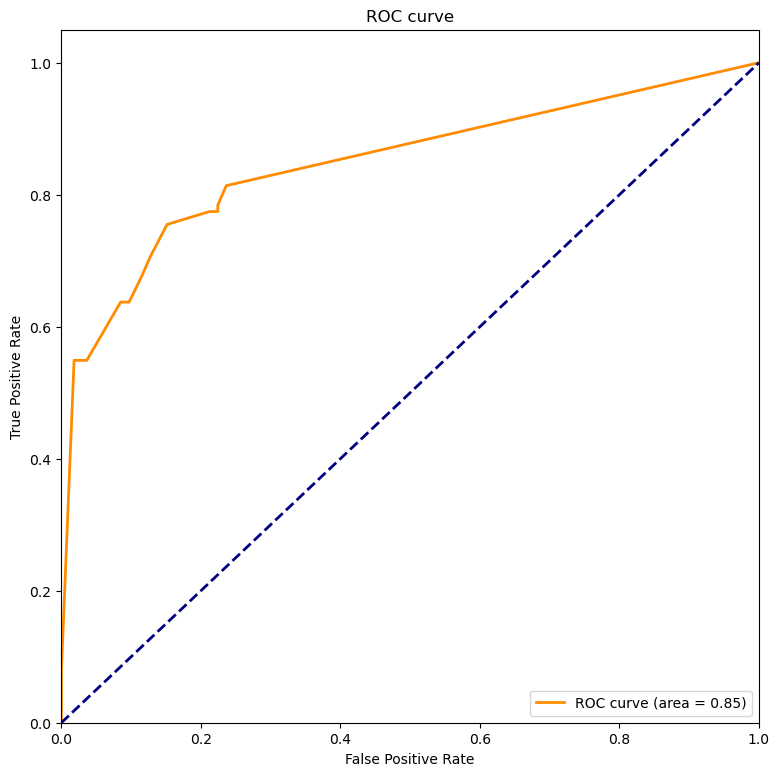

In [26]:
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=model.predict_proba(S_test)[:,1])
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)
plt.figure(figsize=(9, 9))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")
plt.show()

# titanic 데이터에 family열 추가

In [27]:
new_x_train = x_train 
new_x_test = x_test

new_x_train['Family'] = new_x_train.SibSp + new_x_train.Parch
new_x_test['Family'] = new_x_test.SibSp + new_x_test.Parch

In [28]:
new_x_train.drop(columns=['SibSp', 'Parch'], inplace=True)
new_x_test.drop(columns=['SibSp', 'Parch'], inplace=True)

In [29]:
# 연속형 데이터
new_numeric_features = ['Family', 'Age']
# 연속형 데이터 encoder
numeric_transformer = StandardScaler()
# 범주형 데이터
categorical_features = ['Sex', 'Pclass', 'Embarked']
# 범주형 데이터 encoder
categorical_transformer = OneHotEncoder(categories='auto', handle_unknown='ignore') 

new_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, new_numeric_features),
        ('cat', categorical_transformer, categorical_features)],
)

In [30]:
new_preprocessor_pipe = Pipeline(steps=[('preprocessor', new_preprocessor)])

In [31]:
# x_train데이터 학습시키는 과정
new_preprocessor_pipe.fit(new_x_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Family', 'Age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Pclass',
                                                   'Embarked'])]))])

In [32]:
# x_train의 학습을 토대로 One-HotEncoding(), StandardScaler() 적용
new_x_train_transformed = new_preprocessor_pipe.transform(new_x_train)
new_x_test_transformed = new_preprocessor_pipe.transform(new_x_test)

In [33]:
x_train_encoding_new = pd.DataFrame(new_x_train_transformed , columns=['Family', 'Age', 'Female', 'Male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'])
x_test_encoding_new =  pd.DataFrame(new_x_test_transformed , columns=['Family', 'Age', 'Female', 'Male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'])

In [34]:
# Stack하기 위한 모델들
estimators = [ 
    ('ExtraTrees', ensemble.ExtraTreesClassifier(random_state = 0, n_jobs = -1, n_estimators = 100, max_depth = 3)),
    ('RandomForest', ensemble.RandomForestClassifier(random_state = 0, n_jobs = -1, n_estimators = 100, max_depth = 3)),
    ('XGB', XGBClassifier(seed = 0, n_jobs = -1, learning_rate = 0.1, n_estimators = 100, max_depth = 3, eval_metric='mlogloss')),
    ('DecisionTree', DecisionTreeClassifier()),
    ('Logistic', LogisticRegression()),
    ('SVC', SVC(C=1, gamma=0.1, kernel='rbf')),
]

In [35]:
stack = StackingTransformer(estimators, 
                            regression = False, 
                            metric = accuracy_score, 
                            n_folds = 4, stratified = True, shuffle = True, 
                            random_state = 0, verbose = 1) 

In [36]:
# fit을 통해 각 모델들 점수를 보고 학습
stack = stack.fit(x_train_encoding_new, y_train)

# transform을 통해 train결과를 S_train에 넣음
S_train = stack.transform(x_train_encoding_new)
# transform을 통해 test결과를 S_test에 넣음
S_test = stack.transform(x_test_encoding_new)


task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
variant:      [A]
n_estimators: [6]

estimator  0: [ExtraTrees: ExtraTreesClassifier]
    MEAN:     [0.80546940] + [0.02236653]

estimator  1: [RandomForest: RandomForestClassifier]
    MEAN:     [0.81992349] + [0.02087226]

estimator  2: [XGB: XGBClassifier]
    MEAN:     [0.82154673] + [0.00692064]

estimator  3: [DecisionTree: DecisionTreeClassifier]
    MEAN:     [0.77159843] + [0.03660811]

estimator  4: [Logistic: LogisticRegression]
    MEAN:     [0.79419975] + [0.00818505]

estimator  5: [SVC: SVC]
    MEAN:     [0.81830025] + [0.02121109]

Train set was detected.
Transforming...

estimator  0: [ExtraTrees: ExtraTreesClassifier]
    DONE

estimator  1: [RandomForest: RandomForestClassifier]
    DONE

estimator  2: [XGB: XGBClassifier]
    DONE

estimator  3: [DecisionTree: DecisionTreeClassifier]
    DONE

estimator  4: [Logistic: LogisticRegression]
    DONE

estimator  5: [SVC: SVC]
    DONE

Tran

In [37]:
# XGBClassification의 hyper-parameter
params = {
    'learning_rate' : [1, 0.1, 0.01, 0.001],
    'n_estimators' : [100, 1000],
    'max_depth' : [3, 4, 5],
    'eval_metric' : ['mlogloss'],
    'n_jobs' : [-1],
    'seed' : [0],
}

In [38]:
# BayesSearch
opt = BayesSearchCV(
    XGBClassifier(),
    params, 
    n_iter=20,
    random_state=0)

y_pred = opt.fit(S_train, y_train)
y_pred.best_params_

OrderedDict([('eval_metric', 'mlogloss'),
             ('learning_rate', 1.0),
             ('max_depth', 5),
             ('n_estimators', 940),
             ('n_jobs', -1),
             ('seed', 0)])

In [39]:
# HPO 적용
model = XGBClassifier(**y_pred.best_params_) 
# 1단계 결과를 통해 얻은 S_train과 y_train을 다시 학습시킴
model = model.fit(S_train, y_train)

In [40]:
# 결과
y_pred = model.predict(S_test) 
print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred)) # Precision, Recall, F1-score 등을 확인할 수 있습니다.

Final prediction score: [0.81647940]
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       165
           1       0.81      0.68      0.74       102

    accuracy                           0.82       267
   macro avg       0.82      0.79      0.80       267
weighted avg       0.82      0.82      0.81       267



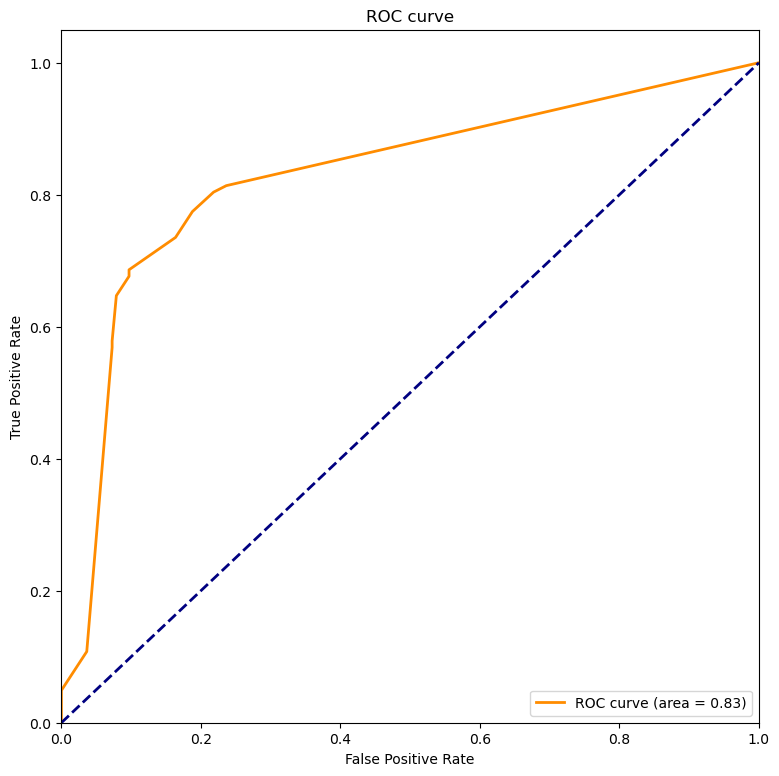

In [41]:
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=model.predict_proba(S_test)[:,1])
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)
plt.figure(figsize=(9, 9))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")
plt.show()

In [44]:
# 파생컬럼 포함 의사결정나무
# 의사결정나무 불러오기
from sklearn.tree import DecisionTreeClassifier

# 의사결정 나무 불러오기 => 학습 시키기

clf = DecisionTreeClassifier()
clf.fit(x_train_encoding_new, y_train)

# y값 예측하기

y_pred = clf.predict(x_test_encoding_new)

# acc 체점

print(accuracy_score(y_test, y_pred))

0.7752808988764045


In [45]:
# GridSearch & SVM

# 아래 param_grid dict 의 C & gamma 에 후보 Hyper-params 값들을 리스트업
param_grid = {'C' : [0.1, 1, 10, 100], 
             'gamma' : [1, 0.1, 0.01, 0.001],
             'kernel' : ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1)

grid.fit(x_train_encoding_new, y_train)
print('The best parameters are ', grid.best_params_)

grid_predictions = grid.predict(x_train_encoding_new)

print("Accuracy on Training set: {:.3f}".format(grid.score(x_train_encoding_new, y_train)))
print("Accuracy on Test set: {:.3f}".format(grid.score(x_test_encoding_new, y_test)))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
The best parameters are  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy on Training set: 0.831
Accuracy on Test set: 0.809
